## Import Package

### General Pacakage

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
sns.set_style("whitegrid")

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pickle

import time

import warnings
warnings.filterwarnings("ignore")

### Scikit-Learn Package

In [2]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

### BERT (Pytorch, Transformer, etc) Package

In [3]:
import psutil
import humanize
import os
import GPUtil as GPU

import torch

from transformers import BertTokenizer

import statistics

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

## Exploratory Data Analysis

### Read Dataset

In [4]:
df_train = pd.read_csv("data_train_clean.csv")
df_test = pd.read_csv("data_test_clean.csv")

In [5]:
df_train.head()

,Tweet_Parsed,HS
0,kadang will be kind enough to show you how to...,0
1,ternyata komunis juga bisa menangis,0
2,user user kenapa harus bom seperti benar men...,0
3,user sumpah kaya kalau habis iya dilanjut olim...,0
4,rt user user user user user fungsi media sosia...,1


### Shape of Data

In [6]:
df_train.shape

(13244, 2)

In [7]:
df_train[df_train['HS'] == 0].head(10)

,Tweet_Parsed,HS
0,kadang will be kind enough to show you how to...,0
1,ternyata komunis juga bisa menangis,0
2,user user kenapa harus bom seperti benar men...,0
3,user sumpah kaya kalau habis iya dilanjut olim...,0
8,happy anniversary failed bulan dengan pria ber...,0
11,hari ini presiden jokowi akan meninjau proyek ...,0
12,kalau gotham city lokasinya di indonesia harve...,0
13,h imam munandar gubernur riau periode dan mem...,0
15,kebijakan presiden jokowi buat pegawai neger...,0
16,aku sebenarnya paling malas bagian ini tetap...,0


In [ ]:
#(temp['HS'].values/sum(temp['HS'])).round()

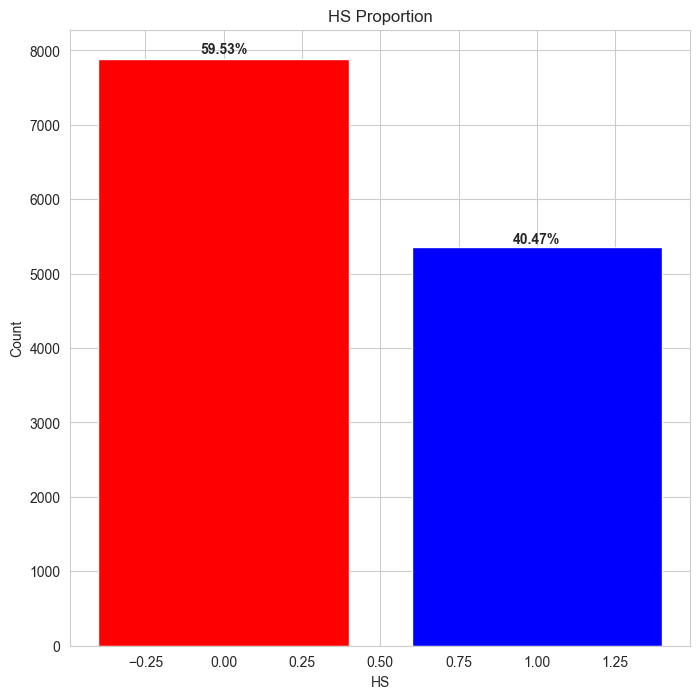

In [8]:
# data_train.groupby('bully').agg(count_bully = ('bully','count')).plot.bar(color=['Blue'],legend=False)

temp = df_train.groupby('HS').agg(count_HS = ('HS','count')).reset_index()

plt.figure(figsize=(8,8))
colors_list = ['red','blue']
graph = plt.bar(temp['HS'],temp['count_HS'], color = colors_list)
plt.title("HS Proportion")
plt.ylabel('Count')
plt.xlabel('HS')

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x,y = p.get_xy()
    plt.text(x+width/2,
            y+height*1.01,
            str(((temp['count_HS'].values/sum(temp['count_HS']))*100).round(2)[i])+'%',
            ha='center',
            weight='bold')
    i+=1

plt.show()

In [9]:
temp

,HS,count_HS
0,0,7884
1,1,5360


In [10]:
df_train.groupby('HS').agg(count_HS = ('HS','count')).reset_index()

,HS,count_HS
0,0,7884
1,1,5360


### Wordcloud

In [11]:
def word_cloud(data, filenames):
    def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return("hsl(0,100%, 1%)")
    columns  = list(data)
    
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

def show_wordcloud(data,title):
    wordcloud = WordCloud(background_color="white", width=1000, height=500, max_words=100).generate_from_frequencies(data)
    # set the word color to black
    wordcloud.recolor(color_func = black_color_func)
    # set the figsize
    plt.figure(figsize=[10,5])
    # plot the wordcloud
    plt.imshow(wordcloud, interpolation="bilinear")
    # remove plot axes
    plt.axis("off")
    plt.title(title)
    # save the image
    # plt.savefig('biden_wc.png')

In [12]:
course_grouped = df_train.groupby('HS')['Tweet_Parsed'].apply(lambda x : " ".join(x)).reset_index()
grouped_tfidf = TfidfVectorizer()
grouped_tfidf.fit(course_grouped['Tweet_Parsed'])
course_grouped_tfidf = pd.DataFrame(grouped_tfidf.transform(course_grouped['Tweet_Parsed']).toarray(),
                                    columns = grouped_tfidf.get_feature_names_out())
course_grouped_tfidf['HS'] = course_grouped['HS']
course_grouped_tfidf = course_grouped_tfidf.set_index("HS").transpose()

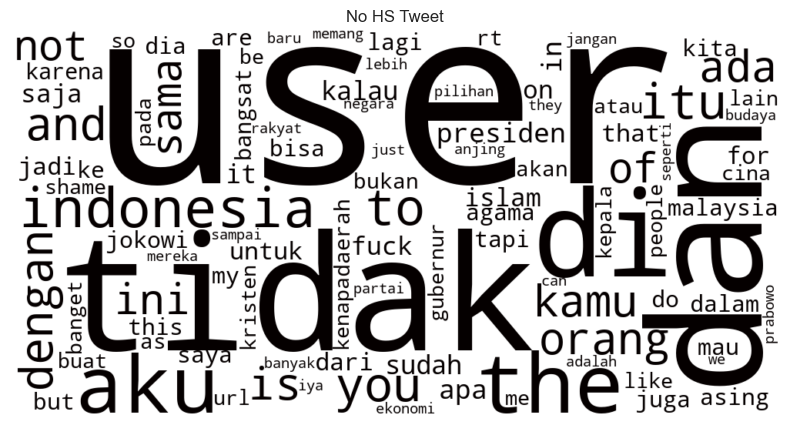

In [13]:
show_wordcloud(course_grouped_tfidf[0],'No HS Tweet')

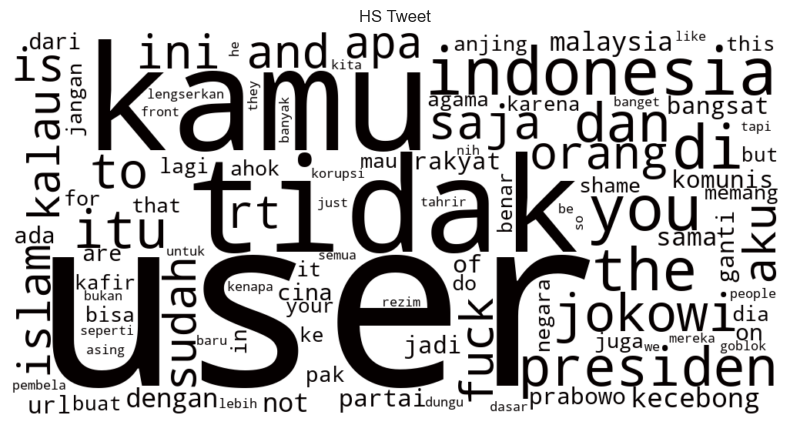

In [14]:
show_wordcloud(course_grouped_tfidf[1],'HS Tweet')

In [15]:
for i in df_train.columns[2:8]:
    course_grouped = df_train[df_train[i] == 1].groupby('HS')['Tweet_Parsed'].apply(lambda x : " ".join(x)).reset_index()
    grouped_tfidf = TfidfVectorizer()
    grouped_tfidf.fit(course_grouped['Tweet_Parsed'])
    course_grouped_tfidf = pd.DataFrame(grouped_tfidf.transform(course_grouped['Tweet_Parsed']).toarray(),
                                        columns = grouped_tfidf.get_feature_names())
    course_grouped_tfidf['HS'] = course_grouped['HS']
    course_grouped_tfidf = course_grouped_tfidf.set_index("HS").transpose()
    
    title = 'HS Tweet: '+str(i)
    show_wordcloud(course_grouped_tfidf[1],title)

### Char Count

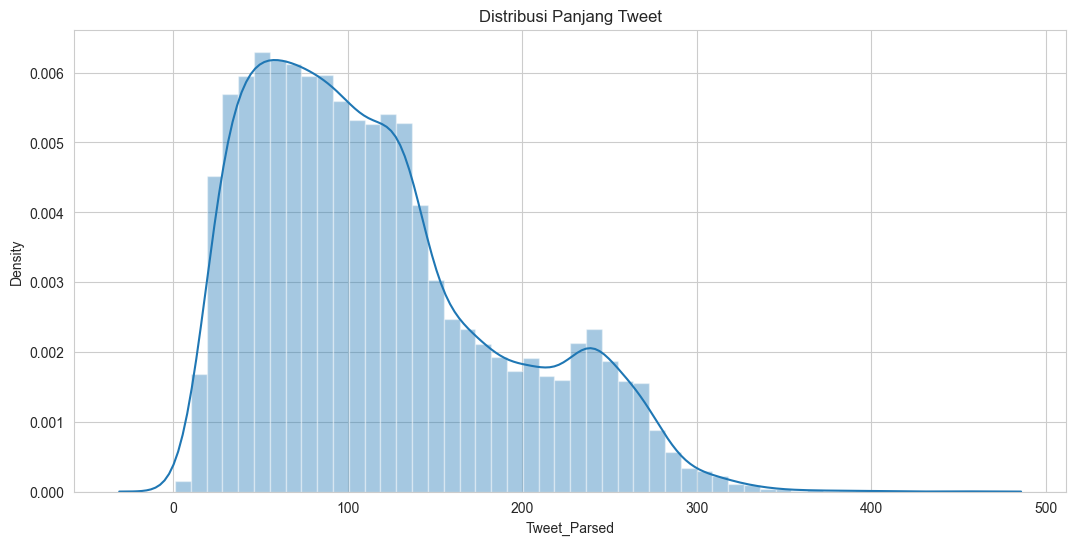

In [16]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_train['Tweet_Parsed'].str.len()).set_title('Distribusi Panjang Tweet');

### Word Count

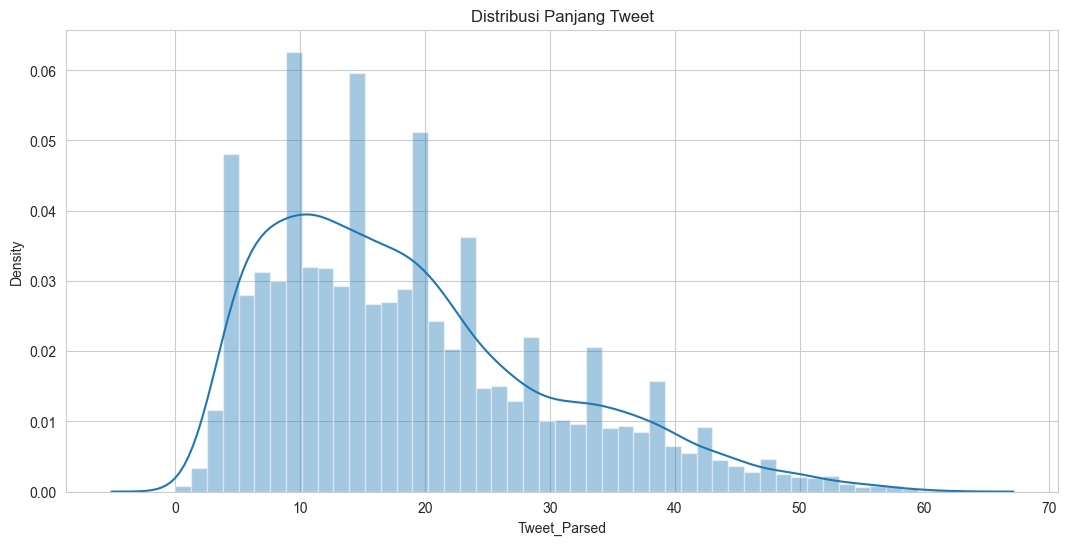

In [17]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_train['Tweet_Parsed'].apply(lambda txt : len(str(txt).split()))).set_title('Distribusi Panjang Tweet');

## Model Training

In [58]:
# X = df_train[['Tweet_Parsed']]
# y = df_train['HS']

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [21]:
X_train = df_train['Tweet_Parsed']
y_train = df_train['HS']

X_test = df_test['Tweet_Parsed']
y_test = df_test['HS']

In [22]:
y_train_enc = y_train.copy()
y_train_enc = y_train_enc.astype(int)

y_test_enc = y_test.copy()
y_test_enc = y_test_enc.astype(int)

### Random Forest

In [72]:
model_rf = RandomForestClassifier(n_jobs=-1)
pipeline_rf = make_pipeline(TfidfVectorizer(ngram_range = (1,1)),model_rf)

In [73]:
param_grid_rf = {'randomforestclassifier__n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
               'randomforestclassifier__min_samples_split': [2, 5, 10],
               'randomforestclassifier__min_samples_leaf': [1, 2, 4],
               'randomforestclassifier__bootstrap': [True, False]
                     }

In [ ]:
grid_search_rf_full = GridSearchCV(estimator=pipeline_rf,
                                     param_grid=param_grid_rf,
                                     cv=3,
                                     n_jobs = -1) 

grid_search_rf_full.fit(X_train,y_train)

In [ ]:
grid_search_rf_full.best_score_

In [ ]:
grid_search_rf_full.best_params_

In [ ]:
grid_search_rf_full.best_estimator_.score(X_test,y_test)

## BERT (indobenchmark)

### Check GPU

In [23]:
torch.cuda.empty_cache()

In [24]:
GPUs = GPU.getGPUs()

# XXX: cek gpu
print("jumlah gpu : ", len(GPUs))

if len(GPUs)>0:
    gpu = GPUs[0]
    def printm():
     process = psutil.Process(os.getpid())
     print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
     print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    printm()

jumlah gpu :  1
Gen RAM Free: 11.6 GB  | Proc size: 408.3 MB
GPU RAM Free: 3937MB | Used: 0MB | Util   0% | Total 4096MB


### Setting Cuda

In [25]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


### Load Bert Tokenizer

In [26]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1", do_lower_case=True)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

### Tokenization

In [28]:
sentences = X_train.values
labels = y_train_enc.astype(int).values

In [29]:
test_sentences = X_test.values

In [30]:
sent_length = []

# For every sentence...
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    token_ids = tokenizer.encode(sent, add_special_tokens=True)
    sent_length.append(len(token_ids))

print('Average length = ', sum(sent_length)/len(sent_length))
print('Median length = ', statistics.median(sent_length))

Average length =  24.28390214436726
Median length =  21.0


In [31]:
# Tokenize all of the sentences and map the tokens to their word IDs.
token_ids  = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 60,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    token_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
token_ids  = torch.cat(token_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
# labels = torch.nn.functional.one_hot(labels.to(torch.int64))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [32]:
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', token_ids[0])
print('Attention Masks:', attention_masks[0])

Original:   kadang will be kind enough to show you how to look berkelas tidak mau punya teman kampungan drinks only the finest wine orang no drinking when he being modest will accompany you to watch movies does not listen to you that much but will know when kamu not ok because he actualy cares about kamu
Token IDs: tensor([    2,  3597, 10925,  1432, 26355,   934,  5392,  6861,  1226,  7586,
         3299, 11088,  1226, 15848, 17398,   119,   422,  1121,  1614,  4237,
            5, 24750, 30362, 12220,  1002, 29918,   764, 22462,   232,   894,
        24750,    55, 20113,  1991, 19502,  2692,  6852,   764, 10925,  6227,
         3425,   854,  3299,  1226, 16271, 15060, 30362,  1782,    53,  3756,
        26655,  1226,  3299,  8666, 16742,  3739, 10925, 11176, 20113,     3])
Attention Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Create Tensor Dataset

In [33]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(token_ids, attention_masks, labels)

# Create a 80-20 train-validation split.
# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

11,919 training samples
1,325 validation samples


In [34]:
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### Create Model and Optimizer


In [35]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1", 
    num_labels = 2, 
    output_attentions = False, # return attentions weights
    output_hidden_states = False, # returns all hidden-states
)

if len(GPUs)>0:
  # Tell pytorch to run this model on the GPU.
  model.cuda()
else:
  # Tell pytorch to run this model on the CPU.
  model.cpu()

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AssertionError: Torch not compiled with CUDA enabled

In [36]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 1e-5, 
                  eps = 1e-8
                )

### Training

In [37]:
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
print('Jumlah batch :', len(train_dataloader))
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Jumlah batch : 373


In [38]:
def acc_score(y_pred,y_test):
    acc_count = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
    return acc_count

In [39]:
# def acc(y_pred,y_test):
#     acc_count = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
#     return acc_count

EPOCHS = epochs

loss_values = []
y_true_val=[]
y_pred_val = []

total_step = len(train_dataloader)

for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    total_train_acc  = 0
    for batch_idx, (token_ids, attention_masks, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        b_input_ids = token_ids.to(device)
        b_input_mask = attention_masks.to(device)
        labels = labels.to(device)

        loss, prediction = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=labels).values()

#         print(batch_idx)
#         print(labels)
        acc = acc_score(prediction, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc  += acc.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    train_acc  = total_train_acc/len(train_dataloader)
    train_loss = total_train_loss/len(train_dataloader)
    model.eval()
    torch.set_grad_enabled(False)

    total_val_acc  = 0
    total_val_loss = 0
    with torch.no_grad():
        for batch_idx, (token_ids, attention_masks, labels) in enumerate(validation_dataloader):
            optimizer.zero_grad()

            b_input_ids = token_ids.to(device)
            b_input_mask = attention_masks.to(device)
            labels = labels.to(device)

            loss, prediction = model(b_input_ids, 
                                  token_type_ids=None, 
                                  attention_mask=b_input_mask, 
                                  labels=labels).values()
            
            acc = acc_score(prediction, labels)

            logits = prediction
            logits = logits.detach().cpu().numpy()
            b_labels = labels.to('cpu').numpy()

            y_pred_val.append(logits)
            y_true_val.append(b_labels)

            total_val_loss += loss.item()
            total_val_acc  += acc.item()

    val_acc  = total_val_acc/len(validation_dataloader)
    val_loss = total_val_loss/len(validation_dataloader)
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

RuntimeError: expected scalar type Long but found Int

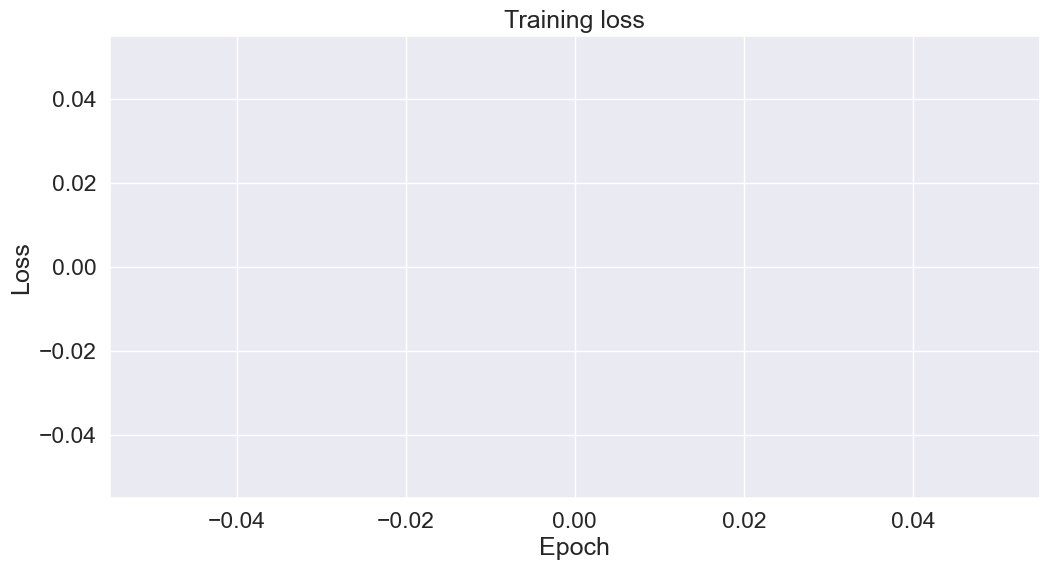

In [40]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### Testing and Evaluation

In [41]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
token_ids  = []
attention_masks = []

# For every sentence...
for sent in test_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 60,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        # padding = 'max_length',
                   )
    
    # Add the encoded sentence to the list.    
    token_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
token_ids = torch.cat(token_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Set the batch size.  
batch_size = 1

# Create the DataLoader.
prediction_data = TensorDataset(token_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [42]:
print('Jumlah batch :', len(prediction_dataloader))

Jumlah batch : 3680


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(token_ids)))

# Put model in evaluation mode
model.eval()
torch.set_grad_enabled(False)

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    
    # Store predictions and true labels
    predictions.append(logits)

print('    DONE.')

Predicting labels for 3,680 test sentences...


In [ ]:
predictions = np.concatenate(predictions, axis=0)
predictions = predictions.argmax(axis=1)

In [ ]:
accuracy_score(predictions,y_test_enc.values)